# Cours "Géomatique"
### Louis Maritaud
### louis.maritaud@unilim.fr

## Objectifs pédagogiques
- Comprendre la structure d'un GeoDataFrame
- Lire et manipuler des fichiers géographiques
- Maîtriser les bases des systèmes de coordonnées (CRS)
- Créer des cartes simples avec matplotlib


# Résumé de ce qu'on a vu 
# Les boucles 
- **for** permet d'itérer sur un nombre défini d'éléments. On peut itérer sur les éléments d'une liste, les caractères d'une chaîne de caractères, etc. Le code **identé** sous `for` sera éxecuté pour chaque itération.     
**Syntaxe**
```python
for element in objet_sur_lequel_on_itère :
    #code à reproduire pour chaque élément
# Une fois que toutes les itérations sont faites
```

# Les conditions
- **if** permet de définir une condition **initiale**. Si la condition est remplie, le bloc de code identé est exécuté. Sinon, on passe à la suite.    
**Syntaxe**
```python
if condition : 
    # code qui s'exécute si la condition est remplie
# En dehors de la condition, le code s'exécutera quoi qu'il advienne
```
- **elif** permet de poser une n-ème condition, si celles qui précèdent ne sont pas remplies. elif = else if. elif doit se situer après un if (obligatoire) et potentiellement après d'autres elif. On peut mettre autant d'elif que l'on souhaite.     
**Syntaxe**
```python
if condition_1 :
    # Code à exécuter si la condition est remplie
elif condition_2 :
    # Code à exécuter si condition_1 n'est pas remplie, mais condition_2 est remplie
# En dehors des conditions, le code s'exécutera quoi qu'il advienne
```
- **else** est un **fallback**. Dans le cas où aucune condition n'est remplie dans les if/elif au dessus, le code s'exécutera.     
**Syntaxe**
```python
if condition_1 :
    # Code à exécuter si la condition est remplie
elif condition_2 :
    # Code à exécuter si condition_1 n'est pas remplie, mais condition_2 est remplie
else :
    # Code à exécuter si condition_1 et condition_2 ne sont pas remplies
# En dehors des conditions, le code s'exécutera quoi qu'il advienne 
```

# Les fonctions
On peut réutiliser des morceaux de code sans avoir à les réécrire. On va alors définir une **fonction**.    
Les **paramètres** sont les variables locales à l'intérieur de la fonction, qui sont définies dans sa programmation.     
Lorsqu'on **appelle** la fonction, on lui passe des **arguments** réels qui correspondent aux paramètres.    
La fonction doit **retourner** le résultat de son éxecution : c'est la commande `return`

**Syntaxe :**
```python
def nom_fonction(parametre1, parametre2):
    # Code de la fonction
    resultat = parametre1 + parametre2
    return resultat
```

# Deux nouveaux types de données
## Les tuples
Les tuples sont comme des listes, on y trouve un nombre défini d'éléments ordonnés. Seulement, les tuples sont immuables : on ne peut pas les modifier directement. Pour modifier un tuple, il faut réaffecter une variable. Ils s'écrivent entre parenthèse, chaque item les composant étant séparé par une virgule:
```python
tuple_exemple=("ceci","est","un","tuple")
```
Les **coordonnées géographiques** sont la plupart du temps des tuples en Python.
## Les booléns
Les booléens sont très simples, ils n'acceptent que deux valeurs : ```True``` et ```False```. Quand vous testez une condition, c'est un booléen qui est renvoyé.

# Pandas et les DataFrame
La manipulation de tableaux en Python se fait à 98% sous la bibliothèque Pandas.     
Pour utiliser une bibliothèque, il faut **l'importer**, une seule fois dans son code :
```python
import pandas
```

Pour éviter de taper le nom complet de la bibliothèque, on peut lui donner un raccourci. Par convention, on utilise "pd" pour pandas :
```python
import pandas as pd
```

## Quelques commandes très utiles
### Créer un DataFrame à partir d'un dictionnaire :
  ```python
  df = pd.DataFrame(dictionnaire)
  ```
  ----
### Voir les x premières lignes d'un DataFrame appelé df :
  ```python
  df.head(x)
  ```
  ----
### Sélectionner une colonne "colonne" dans le DataFrame df :
  ```python
  df["colonne"]
  ```
  ----
### Filtrer les lignes selon une condition portant sur des valeurs de la colonne "colonne" dans le DataFrame df :
  ```python
  df[df["colonne"] condition]
  # Par exemple : 
  df_recent = df[df["annee"] > 1850] # filtre les données dont la colonne "année" a un chiffre supérieur à 1850
  ```
  ----
### Ajouter une colonne :
  ```python
  df["nouvelle colonne"] = liste_qui_comprend_le_même_nombre_d_items_que_de_lignes_dans_le_df
  ```
  ----
### Trier des données sur une colonne "colonne":
  ```python
    # tri alphabétique ou croissant :
  df_trié = df.sort_values("colonne")
    # tri inversé ;
    df_trié= df.sort_values("colonne", ascending=False)
```
  ----
### Charger un fichier
   ```python
   #fichier csv :
   df = pd.read_csv(
       "donnees.csv",
       sep=";",  # Séparateur (parfois ; au lieu de , => quand votre csv vient d'Excel c'est un point-virgule)
       encoding="utf-8"  # Encodage /!\ IMPORTANT
   )
   #fichier Excel :
   df = pd.read_excel("donnees.xlsx", sheet_name="Feuille1")
   ```     

   ----   
### Enregistrer un fichier :
  ```python
  # csv : 
  df.to_csv("resultat.csv", encoding="utf-8", index=False)  # Sans l'index, sinon ça vous rajoute une colonne
  # Excel :
    df.to_excel("resultat.xlsx", encoding="utf-8", index=False)
```



## Partie Théorique

### 1. Introduction à GeoPandas

**Qu'est-ce que GeoPandas ?**
- Extension de Pandas pour les données géographiques
- Même syntaxe que Pandas + colonne spéciale `geometry`
- Supporte shapefile, GeoJSON, GeoPackage, etc.
- Intégration avec matplotlib pour la visualisation

In [ ]:
# Installation et imports
# Installation (à faire une fois)
# pip install geopandas matplotlib contextily

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# Construction d'un DataFrame classique 
df = pd.DataFrame({
    'ville': ['Paris', 'Lyon', 'Marseille', 'Toulouse', 'Limoges'],
    'population': [2103778, 519127, 877215, 514819, 129754], # Données Wikipédia
    'latitude': [48.8566, 45.7640, 43.2965, 43.6048, 45.849998],
    'longitude': [2.3522, 4.8357, 5.3698, 1.4428, 1.25]
})

#Deux manières d'afficher un df dans jupyter : print 
print(f"Notre DataFrame classique : \n{df}")

#ou display (plus joli)
display(df)

In [ ]:
# Conversion en GeoDataFrame
# Créer des géométries Point à partir des coordonnées → points_from_xy
gdf = gpd.GeoDataFrame(
    df, 
    geometry=gpd.points_from_xy(df.longitude, df.latitude),
    crs="EPSG:4326"  # Système de coordonnées WGS84
)

print(gdf)
print(f"\nColonne geometry :\n{gdf.geometry}")
print(f"\nType de la colonne geometry :{type(gdf.geometry)}")

gdf.plot()
plt.show()


In [ ]:
# Ajout du geojson des régions : 
gdf_regions=gpd.read_file("DATA/regions.geojson").to_crs("EPSG:4326") # On lit le geojson et on en fait un geodataframe
ax = gdf_regions.plot(figsize=(20, 10)) # On créé un premier plot à partir du geojson
gdf.plot(ax=ax, color="black") # On ajout à ce premier plot nos points

## Petit point syntaxe de matplotlib
Dans matplotlib (et geopandas est basé là dessus pour faire des cartes), on définit **deux objets** :
- La **figure** : c'est le carré blanc qui englobe le/les graphiques. Communément, on l'appelle `fg`
- L'**axe** : c'est l'endroit où l'on dessine le graphique. Communément, on l'appelle `ax`.

Dans l'exemple au dessus, on ne définit pas de figure : comme on ne plot qu'un seul axe, on a pas besoin de l'englober dans un ensemble, c'est automatique.

In [ ]:
# Exemple avec deux figures concurrentes : 
# Ajout du geojson des régions : 
gdf_regions=gpd.read_file("DATA/departements.geojson").to_crs("EPSG:4326")



xmin, ymin, xmax, ymax = gdf_regions.total_bounds # On va chercher les valeurs extrêmes pour x et y afin de définir les axes


fig, ax = plt.subplots(1, 2, figsize=(20, 20)) # Syntaxe : plt.subplots(nombre de lignes, nombre de colonnes, taille de figure)

for axe in ax: # Puisqu'on a créé deux axes, on peut itérer dessus
    axe.set_aspect('equal')   # X et Y à la même échelle
    axe.set_xlim(xmin-1, xmax+1)  # limites X identiques → correspondent à la valeur au dessus
    axe.set_ylim(ymin-1, ymax+1)  # limites Y identiques → correspondent à la valeur au dessus
    
# Axe 0 : carte des régions
gdf_regions.plot(ax=ax[0], color="lightgrey", edgecolor="black")   # Puisqu'on a deux axes, on accède à l'axe qu'on vise par son index
ax[0].set_title("Régions")    # Titre de l'axe 1

# Axe 1 : points
gdf.plot(ax=ax[1], color="black", markersize=20) # Accès par l'index + taille de point
ax[1].set_title("Points") # Titre de l'axe 2

plt.tight_layout() # Permet de supprimer les marges autour des axes
plt.show()         # On montre la figure

## Quels types de géométrie pour GéoPandas ? 

- **Point** : un lieu précis (== coordonnée unique)
- **LineString** : une ligne (== succession de points)
- **Polygon** : une surface fermée
- **MultiPoint, MultiLineString, MultiPolygon** : collections de géométries, respectivement plusieurs points ; plusieurs lignes ; plusieurs polygones.

**Exemples :**

In [ ]:
from shapely.geometry import Point, LineString, Polygon
import contextily as ctx 

# Géométries en lon/lat
point = Point(2.3522, 48.8566)  # Paris
ligne = LineString([(2.3522, 48.8566), (4.8357, 45.7640)])  # Paris-Lyon

# Polygone autour de Paris
polygone = Polygon([
    (2.2, 48.8),
    (2.6, 48.8),
    (2.4, 49.0)
])

# Création en EPSG:4326
gdf = gpd.GeoDataFrame(
    {'nom': ['Point', 'Ligne', 'Polygone'],
     'geometry': [point, ligne, polygone]},
    crs="EPSG:4326"
)

gdf

### 3. Systèmes de coordonnées - CRS (Coordinate Reference System)

**Les essentiels à retenir** :

| EPSG Code | Nom | Unité | Usage |
|-----------|-----|-------|-------|
| **4326** | WGS84 | degrés | GPS, **Folium**, coordonnées géographiques |
| **2154** | Lambert 93 | mètres | France, **calculs de distances/aires** |
| **3857** | Web Mercator | mètres | Fonds de carte web (Google Maps, OSM) |

In [ ]:
# Vérifier le CRS actuel
print("CRS actuel :", gdf.crs)

# Changer de projection (reprojection)
gdf_lambert = gdf.to_crs("EPSG:2154")   # On créé une nouvelle variable en projection Lambert
print(f"CRS original : {gdf.crs}")
print(f"CRS après reprojection : {gdf_lambert.crs}")

# Comparaison des coordonnées
print("\nCoordonnées en WGS84 (degrés) :")
print(gdf.geometry.head())

print("\nCoordonnées en Lambert 93 (mètres) :")
print(gdf_lambert.geometry.head())

In [ ]:
# Calcul de distance en WGS84 (FAUX !)
paris = Point(2.3522, 48.8566)
limoges = Point(1.25, 45.849998)
distance_deg = paris.distance(limoges)
print(f"Distance en degrés (incorrect) : {distance_deg:.4f}°")

# Calcul de distance en Lambert 93 (CORRECT !)
gdf_villes = gpd.GeoDataFrame({
    'ville': ['Paris', 'Limoges'],
    'geometry': [paris, limoges]
}, crs="EPSG:4326")

gdf_villes_proj = gdf_villes.to_crs("EPSG:2154")
distance_m = gdf_villes_proj.geometry[0].distance(gdf_villes_proj.geometry[1])
print(f"Distance en mètres (correct) : {distance_m:.1f} m")
#Conversion directe des mètres en kilomètres :
print(f"Distance en kilomètres (correct) : {distance_m/1000:.1f} km")
# Résultat attendu : ~345 km

# EXERCICE 1 
Calculez la distance entre Limoges et Oulu, ville de Finlande.
Les coordonnées des points sont en degré. Pour changer la projection, passez par GeoPandas !

In [ ]:
coordonnees = {
    "limoges": (1.25, 45.849998),
    "oulu" : (25.5172719, 64.984683)
}



## Cartes simples

In [ ]:
# Cartes simples avec `.plot()` :
# Carte basique
import matplotlib.pyplot as plt # Représentation
import contextily as ctx # Fonds de carte

print(gdf.crs)
# CRS obligatoire
gdf = gdf.to_crs(epsg=3857)

# 
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Tracé des données
gdf.plot(
    ax=ax,  # Taille de la figure
    color='red',        # Couleur
    markersize=100,     # Taille des points
    edgecolor='black',  # Contour
    linewidth=2         # Épaisseur du contour
)

# Fond de carte
ctx.add_basemap(
    ax,
    zoom=6
)

# Finalisation
ax.set_axis_off()
plt.title("Principales villes de France")
plt.show()
print("On va pas se mentir, c'est pas très joli")

# Création d'une "vraie" carte, sans fond

In [ ]:
import geopandas as gpd
import pandas as pd
import requests
import matplotlib.pyplot as plt

# Charger les contours des départements depuis data.gouv.fr

url = "https://www.data.gouv.fr/fr/datasets/r/90b9341a-e1f7-4d75-a73c-bbc010c7feeb"

r = requests.get(url, verify=True) # requests est une bibliothèque qui permet de faire des requêtes html
r.raise_for_status()               # La fonction raise_for_status permet juste de voir si tout s'est bien passé

# Ici, r est le résultat de la requête envoyée à l'URL précédemment donnée en variable str
# Si on affiche le contenu de la requête, on obtiendra 200 → C'est le code qui dit que la connexion a été établie et le contenu téléchargé
# Exactement comme sur vos navigateurs. Les codes 502 (Bad gateway) ou 404 (not found) sont le même genre de codes renvoyés par des requêtes html.

with open("DATA/departements.geojson", "wb") as file : # La commande with permet d'effectuer le bloc de code avec la condition réalisée.
    file.write(r.content)                              # Ici, on ouvre (open) un fichier dont on spécifie le chemin d'accès en str, le mode d'ouverture (wb = write binary) et on l'affecte à une variable "file" grâce à as
    # .write est une méthode qui permet d'écrire quelque chose dans un fichier ; ici on écrit le "content" de r qui correspond au contenu renvoyé par la requête html.

with open("DATA/departements.geojson", "r", encoding="utf-8") as file: # Même opération qu'au dessus, sauf qu'on lit le fichier ('r' = read ; encoding spécifie l'encodage des données)
    departements = gpd.read_file(file)          # On créé la variable departements en tant que géodataframe en lisant le fichier ouvert dans la variable file
departements=departements.to_crs("EPSG:2154")   # la variable existe, on peut changer son crs 

# Charger les données de populations prises sur le site de l'INSEE
df_pop=pd.read_csv("DATA/donnees_departements.csv", encoding="utf-8", sep=";")

df_pop["nom"]=df_pop["Département"]
departements=pd.merge(departements, df_pop, on="nom")


# Explorer les données
print("Premières lignes :")
print(departements.head())

print("\nColonnes disponibles :")
print(departements.columns)

print(f"\nSystème de coordonnées : {departements.crs}")
print(f"Nombre de départements : {len(departements)}")

# Types de géométries
print("\nTypes de géométries :")
print(departements.geometry.type.value_counts())

# Tracer les données sans rien spécifier
departements.plot() # On trace
plt.title("Départements français", fontsize=16) # On définit un tite, avec la taille de police
plt.axis('off') # On enlève les axes

In [ ]:
# Carte de France simple
fig, ax = plt.subplots(figsize=(12, 12))
departements.plot(ax=ax, edgecolor='black', facecolor='lightblue')
plt.title("Départements français", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

# Afficher quelques noms de départements
print("\nPremiers départements :")
print(departements['nom'].head(15))



# Statistiques sur les géométries
print(f"\nSuperficie totale : {departements.geometry.area.sum()/1_000_000  :.2f} km²")

# EXERCICE 2
Vous allez tracer la carte du Brésil et de ses régions à partir du json contenu dans `DATA/br.json`

In [ ]:
# Votre code ici
with open("DATA/br.json", "r", encoding="utf-8") as file: # Même opération qu'au dessus, sauf qu'on lit le fichier ('r' = read ; encoding spécifie l'encodage des données)
    departements = gpd.read_file(file)          # On créé la variable departements en tant que géodataframe en lisant le fichier ouvert dans la variable file
departements=departements.to_crs("EPSG:2154") 

print(departements["name"].to_list())



# Représentation de données numériques 

In [ ]:
# Personnalisation avancée
# Carte avec légende et couleurs selon une variable
fig, ax = plt.subplots(figsize=(12, 10))

departements.plot(
    ax=ax,
    column='PTOT',        # Colorier selon la population → colonne PTOT
    cmap='YlOrRd',        # Palette de couleurs
    legend=True,
    edgecolor="black",
    legend_kwds={'label': "Population (en millions)"}
)



plt.title("Population des départements français")
plt.axis('off')  # Masquer les axes
plt.tight_layout()
plt.show()

## Palettes de couleurs disponibles pour MatPlotLib 
Visibles via ce lien    
[Palettes de couleurs disponibles avec Matplotlib](https://matplotlib.org/stable/users/explain/colors/colormaps.html)    
Ou cette commande :    

In [ ]:
from matplotlib import colormaps
list(colormaps)

# EXERCICE 3 : 
A partir du gdf des départements qu'on manipule depuis le début, produisez une carte avec la sémiologie de votre choix qui représente les départements selon leur nombre de communes (NBCOM).    
Utilisez une autre palette de couleurs que YlOrRd.

In [ ]:
# Votre code ici

# EXERCICE 4 :
Vous opérerez une jointure des données de l'Instituto Brasileiro de Geografia e Estatistica qui recense la population par État. Je vous ai déjà préparé un fichier csv simplifié des données réelles, accessible à `DATA/pop_br.csv`     
A partir de cette jointure, cartographiez les États du Brésil selon leur population.

In [ ]:
# Votre code ici

# Filtrage des données, et représentation de sous ensembles

In [ ]:
# On peut déjà regarder à quoi ressemble notre gdf grâce à .head()
departements.head()

In [ ]:
#====================================================
# METHODE 1 - la plus simple, mais la plus verbeuse
#====================================================

# Filtrer par noms de départements
# On créé une liste avec les noms des départements que l'on vise, puisqu'ils sont disponibles en valeurs de notre dictionnaire
departements_na = ['Dordogne', 'Gironde', 'Landes', 'Lot-et-Garonne', 
                   'Pyrénées-Atlantiques', 'Deux-Sèvres', 'Vienne', 
                   'Haute-Vienne', 'Charente', 'Charente-Maritime', 
                   'Corrèze', 'Creuse']

nouvelle_aquitaine = departements[departements['nom'].isin(departements_na)].copy()  # .copy() pour éviter les effets de bords dont on a déjà parlé !
# La méthode isin() teste pour chaque élément d'un df si il est compris dans une liste
# Renvoie True quand c'est le cas, et du coup ne filtre que sur les True

#================================================================================================
# METHODE 2 - Légèrement plus complexe, mais implique d'avoir le nom de région dans les données
#================================================================================================

# Filtrer par nom de région

nouvelle_aquitaine_2 = departements[departements['Région']=="Nouvelle-Aquitaine"].copy() # .copy() pour éviter les effets de bords dont on a déjà parlé !

if len(nouvelle_aquitaine.compare(nouvelle_aquitaine_2)) == 0:              # .compare() renvoie un df qui contient les différences entre deux df
    print("Les deux premières méthodes renvoient les mêmes départements")
    
#========================================================
# METHODE 3 - La plus complexe, mais la plus Python-like
#========================================================

# Méthode 3 : Si un code région existe
code_na = departements["REG"].loc[departements["Région"] == "Nouvelle-Aquitaine"].iloc[0]
nouvelle_aquitaine_3 = departements[departements['REG'] == code_na].copy()  # .copy() pour éviter les effets de bords dont on a déjà parlé !
if len(nouvelle_aquitaine.compare(nouvelle_aquitaine_3)) == 0:              # .compare() renvoie un df qui contient les différences entre deux df
    print("Les trois méthodes renvoient les mêmes départements")


print(f"Nombre de départements en Nouvelle-Aquitaine : {len(nouvelle_aquitaine)}")
# Visualiser
fig, ax = plt.subplots(figsize=(10, 10))
nouvelle_aquitaine.plot(ax=ax, edgecolor='black', facecolor='#90EE90')
plt.title("Nouvelle-Aquitaine", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

# Calculs de superficie, identification de valeurs minimum et maximum

In [ ]:
# Calcul de superficie avec gpd 
# méthode .area
nouvelle_aquitaine["superficie"]= nouvelle_aquitaine.geometry.area / 1_000_000

# Recherche de valeur max et min sur les départements de la Nouvelle-Aquitaine
plus_grand = nouvelle_aquitaine.loc[nouvelle_aquitaine['superficie'].idxmax()]
print(f"Plus grand département : {plus_grand['nom']} ({plus_grand['superficie']:.0f} km²)")

plus_petit = nouvelle_aquitaine.loc[nouvelle_aquitaine['superficie'].idxmin()]
print(f"Plus petit département : {plus_petit['nom']} ({plus_petit['superficie']:.0f} km²)")

# Exercice 5
- Filtrer une autre région (Bretagne, PACA, etc.)
- Compter le nombre de départements par région
- Identifier le plus grand département (en superficie)

In [ ]:
# Votre code ici
# Pour rappel, dans la variable departements on a déjà tous les départements :
display(departements)

## Cartes choroplèthes

In [ ]:
# Carte avec gradient de couleurs selon la population
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

nouvelle_aquitaine.plot(
    column='PTOT',     # Variable à visualiser
    cmap='YlOrRd',          # Palette : jaune / orange / rouge : Y(el)l(ow)Or(ange)R(e)d
    legend=True,
    edgecolor='black',
    linewidth=0.8,
    ax=ax,
    legend_kwds={
        'label': "Population",
        'orientation': "horizontal",
        'shrink': 0.5
    }
)

plt.title("Population par département - Nouvelle-Aquitaine", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Ajout des départements 
# Calculer les centroïdes (centres) des polygones
nouvelle_aquitaine['centroid'] = nouvelle_aquitaine.geometry.centroid

fig, ax = plt.subplots(1, 1, figsize=(14, 12))

nouvelle_aquitaine.plot(
    column='PTOT', 
    cmap='YlOrRd', 
    legend=True,
    edgecolor='black',
    linewidth=0.8,
    ax=ax
)

# Ajouter les labels au centre de chaque département
for idx, row in nouvelle_aquitaine.iterrows():
    plt.annotate(
        text=row['nom'], 
        xy=(row['centroid'].x, row['centroid'].y),
        horizontalalignment='center',
        fontsize=9,
        color='black'
    )

plt.title("Population par département - Nouvelle-Aquitaine", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

# Exercice 6
Faites exactement la même chose sur les données du Brésil → calcul de centroïdes et ajout du nom des états au centre de chaque état

In [59]:
# Votre code ici 

# Variables manuelles, bins et classes : vraie Choroplèthe

## Discrétisation de valeurs continues avec pandas : la méthode .cut()

In [ ]:
import matplotlib.colors as mcolors

# Définir des classes
bins = [0, 300000, 500000, 1000000, 2000000]        # On appelle "bins" les seuils de valeurs discrets
labels = ['< 300k', '300-500k', '500k-1M', '> 1M']  # labels : noms

nouvelle_aquitaine['classe_pop'] = pd.cut(    # la méthode .cut() de pandas permet de discrétiser des valeurs continues. 
    nouvelle_aquitaine['PTOT'],               # sur la colonne donnée comprenant des valeurs continues
    bins=bins,                                # On sépare les valeurs en unités discrètes
    labels=labels                             # Et on attribue à chaque classe un label prédeterminé
)
display(nouvelle_aquitaine)

## On dessine la carte avec nos valeurs discrètes 

In [ ]:
# Carte avec classes discrètes
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

nouvelle_aquitaine.plot(
    column='classe_pop',     # On plot sur la colonne "classe_pop" qu'on vient de créer
    categorical=True,        # Ici n'est pas nécessaire, mais permet d'indiquer à gpd que les valeurs sont discrètes
    legend=True,             #affiche la légende
    edgecolor='black',       # contours des polygones en noir
    linewidth=0.8,           # épaisseur des contours
    cmap='RdYlGn_r',         # Inversé → _r à la fin : rouge = forte pop
    ax=ax                    # On plot sur ax
)

plt.title("Classes de population - Nouvelle-Aquitaine", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

# Calcul de densité 

In [ ]:
# Calculer la densité (habitants/km²)
nouvelle_aquitaine_proj = nouvelle_aquitaine.to_crs("EPSG:2154")
nouvelle_aquitaine_proj['superficie_km2'] = (
    nouvelle_aquitaine_proj.geometry.area / 1_000_000
)
nouvelle_aquitaine_proj['densite'] = (
    nouvelle_aquitaine_proj['PTOT'] / 
    nouvelle_aquitaine_proj['superficie_km2']
)

# Cartographier
fig, ax = plt.subplots(figsize=(12, 12))
nouvelle_aquitaine_proj.plot(
    column='densite',
    cmap='cool',
    legend=True,
    edgecolor='black',
    ax=ax,
    legend_kwds={'label': "Densité (hab/km²)"}
)
plt.title("Densité de population")
plt.axis('off')
plt.show()

# Statistiques
print(f"Densité moyenne : {nouvelle_aquitaine_proj['densite'].mean():.1f} hab/km²")
print(f"Département le plus dense : {nouvelle_aquitaine_proj.loc[nouvelle_aquitaine_proj['densite'].idxmax(), 'nom']}")
print(f"Département le moins dense : {nouvelle_aquitaine_proj.loc[nouvelle_aquitaine_proj['densite'].idxmin(), 'nom']}")

# Exercice 7 
Calculez la densité de chaque état du Bresil, puis projetez la dans une Choroplèthe aux valeurs discrétisées. 

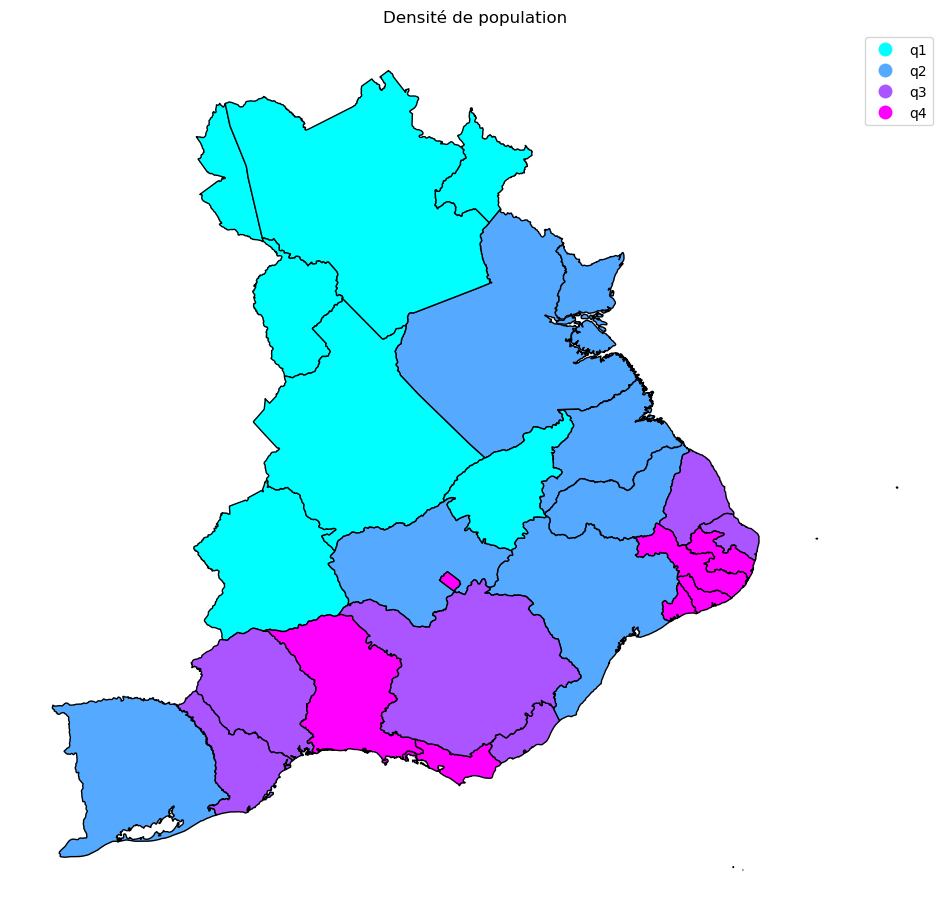